# Train classifiers on BirdNET or Perch embeddings

This notebook shows examples of how to train simple one-layer or multi-layer fully-connected neural networks (aka multi-layer perceptron networks, MLPs) on Perch [1] and BirdNET [2], which are TensorFlow models. For a more general introduction to transfer learning tools in OpenSoundscape see the `transfer_learning.ipynb` notebook, which focuses on PyTorch (rather than Tensorflow) embedding models. 

Though BirdNET and Perch are TensorFlow models, we can still use them as feature extractors (to generate embeddings) and train shallow classifiers on top of them with PyTorch. We just won't be able to train the feature extractor weights at all. 

For this notebook, you'll need a Python environment with `tensorflow` and `tensorflow-hub` packages installed. If you want cuda gpu acceleration on a linux machine, check this [table](https://www.tensorflow.org/install/source#gpu) for the `tensorflow` and `cudnn` package versions you'll need to be compatible with your current CUDA version (you can check the cuda version on your machine by calling `nvidia-smi` from command line). Note that the `cudnn` package version might conflict with which version PyTorch wants, so we recommend creating separate Python environments for pytorch and tensorflow cuda-compatability. 

Note that in this tutorial, all classifiers are trained as multi-target (each class is predicted independently, such that any sample can have 0, 1, or >1 classes present). Most bioacoustics classification tasks are multi-target. 

## preparing your python environment
This notebook uses the [bioacoustics_model_zoo](https://github.com/kitzeslab/bioacoustics-model-zoo), so you'll want to install that repository as a package in your python environment. After installing, be sure to restart this notebook's kernel so that the model zoo is available. From command line, you can install the model zoo from github using

`pip install git+https://github.com/kitzeslab/bioacoustics-model-zoo`

If you want a specific version (aka tag or release) of the model zoo, you can specify it after an @ symbol:

`pip install git+https://github.com/kitzeslab/bioacoustics-model-zoo@0.11.0.dev1`


> [1] Ghani, B., T. Denton, S. Kahl, H. Klinck, T. Denton, S. Kahl, and H. Klinck. 2023. Global birdsong embeddings enable superior transfer learning for bioacoustic classification. Scientific Reports 13:22876.
>
> [2] Kahl, Stefan, et al. "BirdNET: A deep learning solution for avian diversity monitoring." Ecological Informatics 61 (2021): 101236.


## Run this tutorial

This tutorial is more than a reference! It's a Jupyter Notebook which you can run and modify on Google Colab or your own computer.

|Link to tutorial|How to run tutorial|
| :- | :- |
| [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kitzeslab/opensoundscape/blob/master/docs/tutorials/train_cnn.ipynb) | The link opens the tutorial in Google Colab. Uncomment the "installation" line in the first cell to install OpenSoundscape. |
| [![Download via DownGit](https://img.shields.io/badge/GitHub-Download-teal?logo=github)](https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/kitzeslab/opensoundscape/blob/master/docs/tutorials/train_cnn.ipynb) | The link downloads the tutorial file to your computer. Follow the [Jupyter installation instructions](https://opensoundscape.org/en/latest/installation/jupyter.html), then open the tutorial file in Jupyter. |

In [14]:
# if this is a Google Colab notebook, install opensoundscape in the runtime environment
if 'google.colab' in str(get_ipython()):
  %pip install git+https://github.com/kitzeslab/opensoundscape@develop ipykernel==5.5.6 ipython==7.34.0 pillow==9.4.0
  %pip install git+https://github.com/kitzeslab/bioacoustics-model-zoo
  num_workers=0
else:
  num_workers=4

## Setup

### Import needed packages

In [1]:
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random 
from glob import glob
import sklearn

from tqdm.autonotebook import tqdm
from sklearn.metrics import average_precision_score, roc_auc_score
from pathlib import Path

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

# opensoundscape transfer learning tools
from opensoundscape.ml.shallow_classifier import MLPClassifier, quick_fit, fit_classifier_on_embeddings


/var/folders/d8/265wdp1n0bn_r85dh3pp95fh0000gq/T/ipykernel_64650/4234765199.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Set random seeds

Set manual seeds for Pytorch and Python. These essentially "fix" the results of any stochastic steps in model training, ensuring that training results are reproducible. You probably don't want to do this when you actually train your model, but it's useful for debugging.

In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

### Download and prepare training data


#### Download example files
Download a set of aquatic soundscape recordings with annotations of _Rana sierrae_ vocalizations. If you already have them, you can skip this step. 

Option 1: run the cell below

- if you get a 403 error, DataDryad suspects you are a bot. Use Option 2. 

Option 2:

- Download and unzip the `rana_sierrae_2022.zip` folder containing audio and annotations from this [public Dryad dataset](https://datadryad.org/stash/dataset/doi:10.5061/dryad.9s4mw6mn3#readme)
- Move the unzipped `rana_sierrae_2022` folder into the current folder

In [3]:
# Note: the "!" preceding each line below allows us to run bash commands in a Jupyter notebook
# If you are not running this code in a notebook, input these commands into your terminal instead
!wget -O rana_sierrae_2022.zip https://datadryad.org/stash/downloads/file_stream/2722802;
!unzip rana_sierrae_2022;

--2025-01-23 15:20:14--  https://datadryad.org/stash/downloads/file_stream/2722802
Resolving datadryad.org (datadryad.org)... 54.186.205.95, 52.12.146.88, 44.229.212.56, ...
Connecting to datadryad.org (datadryad.org)|54.186.205.95|:443... connected.
HTTP request sent, awaiting response... 403 Forbidden
2025-01-23 15:20:14 ERROR 403: Forbidden.

Archive:  rana_sierrae_2022.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
Archive:  rana_sierrae_2022.ZIP
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.


#### Prepare audio data
See the train_cnn.ipynb tutorial for step-by-step walkthrough of this process, or just run the cells below to prepare a trainig set.

In [4]:
# Set the current directory to where the folder `rana_sierrae_2022` is located:
dataset_path = Path("./rana_sierrae_2022/")

# let's generate clip labels of 5s duration (to match Perch input duration) using the raven annotations
# and some utility functions from opensoundscape
from opensoundscape.annotations import BoxedAnnotations

audio_and_raven_files = pd.read_csv(f"{dataset_path}/audio_and_raven_files.csv")
# update the paths to where we have the audio and raven files stored
audio_and_raven_files["audio"] = audio_and_raven_files["audio"].apply(
    lambda x: f"{dataset_path}/{x}"
)
audio_and_raven_files["raven"] = audio_and_raven_files["raven"].apply(
    lambda x: f"{dataset_path}/{x}"
)

annotations = BoxedAnnotations.from_raven_files(
    raven_files=audio_and_raven_files["raven"],
    audio_files=audio_and_raven_files["audio"],
    annotation_column="annotation",
)
# generate labels for 5s clips, including any labels that overlap by at least 0.2 seconds
labels = annotations.clip_labels(clip_duration=3, min_label_overlap=0.2)

/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/annotations.py:300: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_annotations_df = pd.concat(all_file_dfs).reset_index(drop=True)


#### Inspect labels

Count number of each annotation type: 

Note that the 'X' label is for when the annotator was uncertain about the identity of a call. Labels A-E denote distinct call types.

In [5]:
labels.sum()

A    585
E    154
D     61
B     22
C     91
X    120
dtype: int64

#### split into training and validation data
We'll just focus on class 'A', the call type with the most annotations. We'll randomly split the clips into training and validation data, acknowledging that this approach does not test the ability of the model to generalize. Since the samples in the training and validation sets could be adjascent 2-second audio clips, good performance could simply mean the model has memorized the training samples, and the validation set has very similar samples. 

In [ ]:
labels_train, labels_val = sklearn.model_selection.train_test_split(labels[["A"]])

## Train classification head on BirdNET

The BirdNET and Perch models provided in the Bioacoustics Model Zoo have a `.tf_model` attribute containing the TensorFlow inference model and a `.network` attribute containing a trainable PyTorch classification head, specifically an instance of the MLPCLassifier class. To train a custom classifier on the embeddings extracted by these models, we just need to (1) embed the training and validation samples, then (2) pass the embeddings and labels to the `.network.fit()` method. 

This is equivalent to passing the `.network` to the the `opensoundscape.ml.shallow_classifier.quick_fit()` method, so you can also experiment with generating your own classification heads (e.g. various instances of MLPClassifier) and fitting each of them on the embeddings. See the transfer learning tutorial for further examples. 

#### First, get BirdNET from the Bioacoustics Model Zoo

In [7]:
import bioacoustics_model_zoo as bmz

birdnet = bmz.BirdNET()

File BirdNET_GLOBAL_6K_V2.4_Labels_af.txt already exists; skipping download.
downloading model from URL...
File BirdNET_GLOBAL_6K_V2.4_Model_FP16.tflite already exists; skipping download.


/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:621: UserWarning: 
                    This architecture is not listed in opensoundscape.ml.cnn_architectures.ARCH_DICT.
                    It will not be available for loading after saving the model with .save() (unless using pickle=True). 
                    To make it re-loadable, define a function that generates the architecture from arguments: (n_classes, n_channels) 
                    then use opensoundscape.ml.cnn_architectures.register_architecture() to register the generating function.

                    The function can also set the returned object's .constructor_name to the registered string key in ARCH_DICT
                    to avoid this warning and ensure it is reloaded correctly by opensoundscape.ml.load_model().

                    See opensoundscape.ml.cnn_architectures module for examples of constructor functions
                    
  warnings.warn(
/Users/SML161/mini

#### Second, generate embeddings on the training and validation samples

In general, generating embeddings will take a bit of time (because it requires loading, preprocessing, and embedding samples) but training shallow classifiers will be fast. 

In [9]:
emb_train = birdnet.embed(labels_train, return_dfs=False, batch_size=128, num_workers=0)
emb_val = birdnet.embed(labels_val, return_dfs=False, batch_size=128, num_workers=0)

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

#### Third, fit the shallow classifier on the desired classes

In [10]:
# We want to train the classifier on the 'A' class here, corresponding to the primary R. sierrae call type.
# Let's replace fc output layer with 1-output layer for class 'A'
classes = ["A"]
birdnet.change_classes(classes)

# fit the classification head with embeddings and labels
birdnet.network.fit(emb_train, labels_train.values, emb_val, labels_val.values)

Epoch 100/1000, Loss: 0.32756081223487854, Val Loss: 0.3364783227443695
val AU ROC: 0.819
val MAP: 0.819
Epoch 200/1000, Loss: 0.28670668601989746, Val Loss: 0.32185667753219604
val AU ROC: 0.823
val MAP: 0.823
Epoch 300/1000, Loss: 0.2620905339717865, Val Loss: 0.32191240787506104
val AU ROC: 0.823
val MAP: 0.823
Epoch 400/1000, Loss: 0.24402306973934174, Val Loss: 0.3261476159095764
val AU ROC: 0.819
val MAP: 0.819
Epoch 500/1000, Loss: 0.22927404940128326, Val Loss: 0.3314577043056488
val AU ROC: 0.815
val MAP: 0.815
Epoch 600/1000, Loss: 0.21648067235946655, Val Loss: 0.3369144797325134
val AU ROC: 0.811
val MAP: 0.811
Epoch 700/1000, Loss: 0.20501203835010529, Val Loss: 0.34233540296554565
val AU ROC: 0.809
val MAP: 0.809
Epoch 800/1000, Loss: 0.19454476237297058, Val Loss: 0.34776028990745544
val AU ROC: 0.805
val MAP: 0.805
Epoch 900/1000, Loss: 0.18489131331443787, Val Loss: 0.35326841473579407
val AU ROC: 0.803
val MAP: 0.803
Epoch 1000/1000, Loss: 0.17592892050743103, Val Los

#### Fourth, evaluate the classifier on the validation set

In [11]:
# make predictions by passing the embeddings through the classifier
preds = birdnet.network(torch.tensor(emb_val)).detach()
# calculate the area under the ROC score
roc_auc_score(labels_val.values, preds, average=None)

0.902668759811617

to visualize the performance, let's plot histograms of classifier logit scores for positive and negative samples

it shows that precision is ok for scores above 2 (few negatives get high scores), but recall is only moderate (many positive samples get low scores)

/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


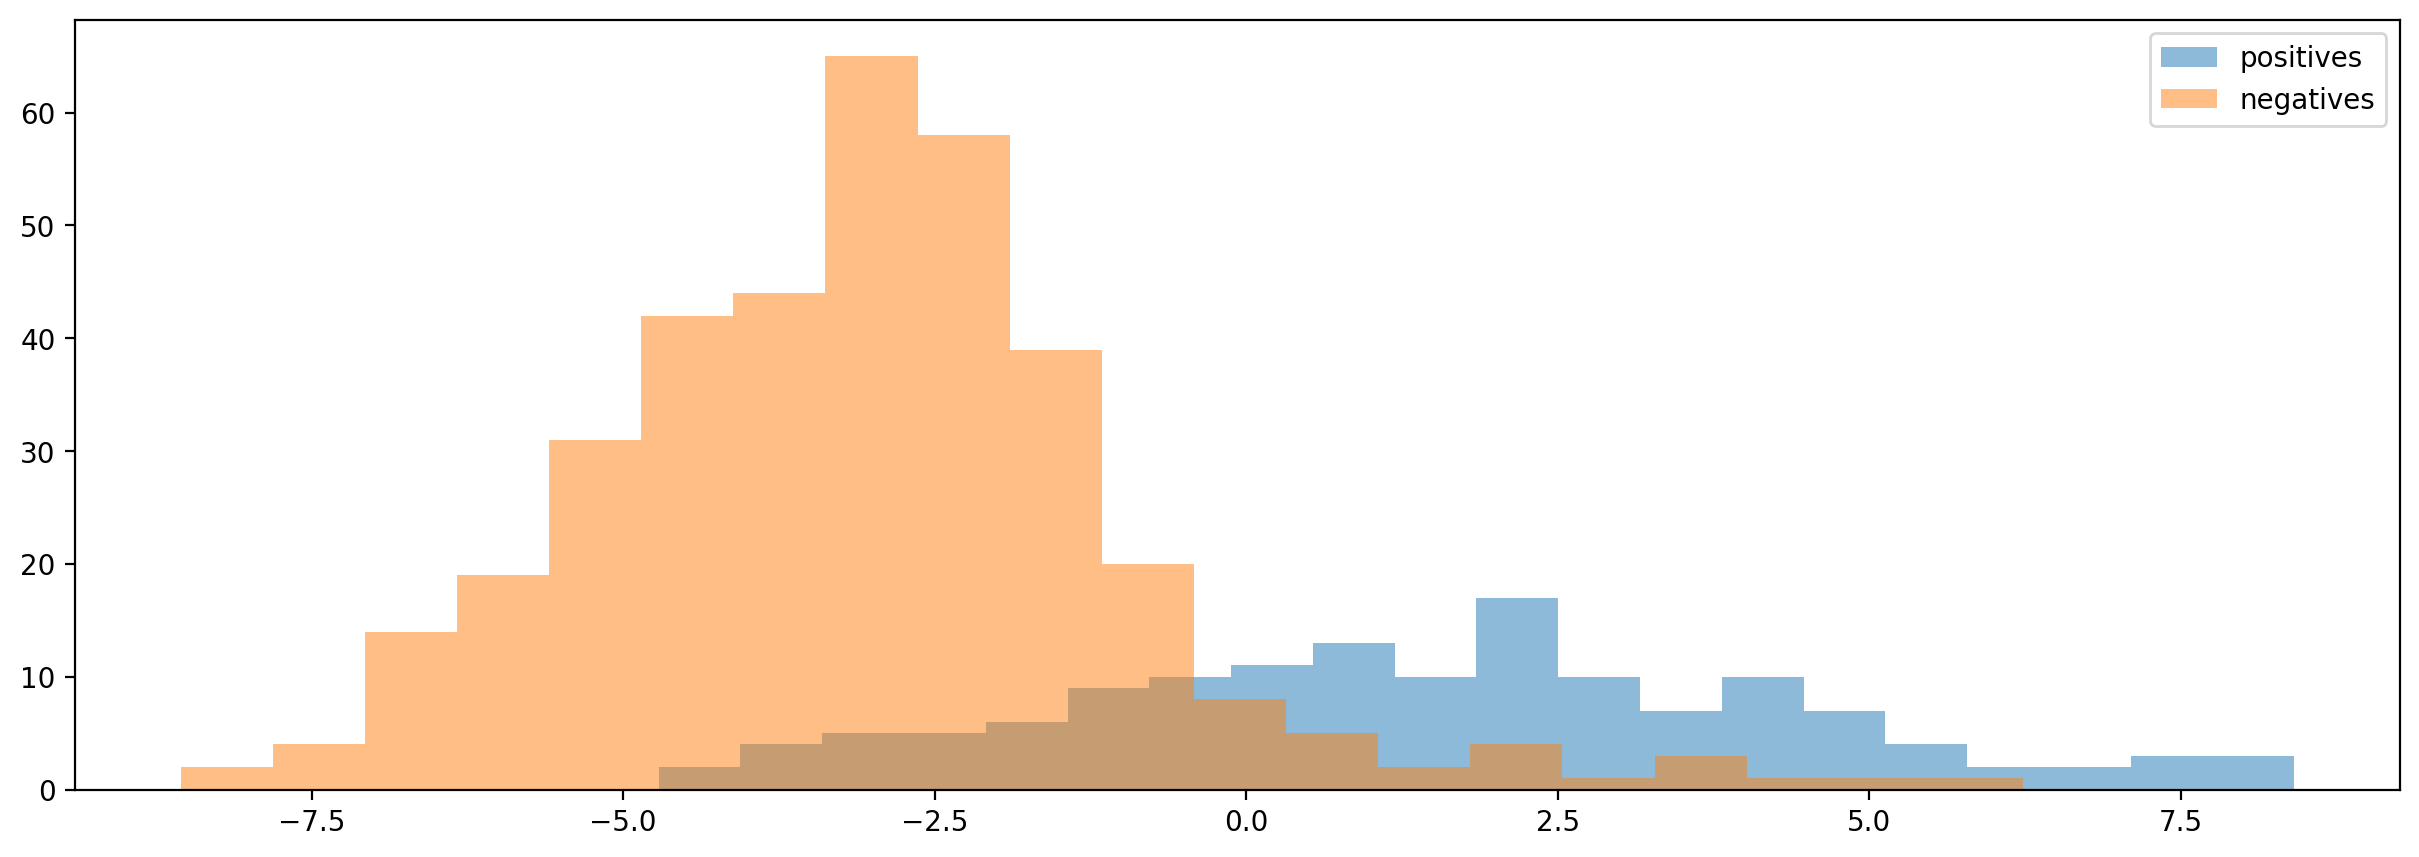

In [12]:
preds = preds.detach().numpy()
plt.hist(preds[labels_val == True], bins=20, alpha=0.5, label="positives")
plt.hist(preds[labels_val == False], bins=20, alpha=0.5, label="negatives")
plt.legend()

### simplifying training into a single function call

We can use the .train() function to combine these steps into one line of code: the function first creates embeddings, then fits the shallow classifier using the embeddings and the labels. It also reports performance on the validation set. This function is designed to look very similar to the Opensoundscape.CNN.train() method, but note that it is doing something different: it begins by creating embeddings using the pre-trained model, and only trains the classification head, not the entire model architecture (the feature extraction layers remain unchanged). 

The advantage of taking each step separately (as shown above) is that once we create the embeddings, we can rapidly try fitting different shallow classifiers.

In [15]:
birdnet.change_classes(classes)
birdnet.train(
    train_df=labels_train,
    validation_df=labels_val,
    embedding_batch_size=128,
    embedding_num_workers=num_workers,
    steps=1000,
)

Embedding the training samples without augmentation


  0%|          | 0/12 [00:00<?, ?it/s]

Embedding the validation samples


  0%|          | 0/4 [00:00<?, ?it/s]

Fitting the classifier
Epoch 100/1000, Loss: 0.15343423187732697, Val Loss: 0.3771530091762543
val AU ROC: 0.795
val MAP: 0.795
Epoch 200/1000, Loss: 0.13392987847328186, Val Loss: 0.3971253037452698
val AU ROC: 0.788
val MAP: 0.788


/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/shallow_classifier.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels, dtype=torch.float32, device=device)
/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

Epoch 300/1000, Loss: 0.1180996373295784, Val Loss: 0.4176616370677948
val AU ROC: 0.780
val MAP: 0.780
Epoch 400/1000, Loss: 0.10501344501972198, Val Loss: 0.43849629163742065
val AU ROC: 0.775
val MAP: 0.775
Epoch 500/1000, Loss: 0.09400373697280884, Val Loss: 0.45953887701034546
val AU ROC: 0.772
val MAP: 0.772
Epoch 600/1000, Loss: 0.08461439609527588, Val Loss: 0.4807313084602356
val AU ROC: 0.770
val MAP: 0.770
Epoch 700/1000, Loss: 0.07651711255311966, Val Loss: 0.502007007598877
val AU ROC: 0.766
val MAP: 0.766
Epoch 800/1000, Loss: 0.06946893036365509, Val Loss: 0.5233026742935181
val AU ROC: 0.764
val MAP: 0.764
Epoch 900/1000, Loss: 0.06328653544187546, Val Loss: 0.5445605516433716
val AU ROC: 0.761
val MAP: 0.761
Epoch 1000/1000, Loss: 0.057828787714242935, Val Loss: 0.5657300353050232
val AU ROC: 0.758
val MAP: 0.758
Training complete


### adjusting the shallow classifier architecture
By default, we are training a single fully-connected neural network layer to map from the embeddings (feature vectors) to the class predictions, which is equivalent to logistic regression. We can easily modify the structure of the shallow classifier to a multi-layer network. For instance, let's make a 2-layer artificial neural network with a hidden layer of size (100,):

In [ ]:
# replace the classification head with a 2-layer MLP (2 fully-connected layers)
birdnet.initialize_custom_classifier(hidden_layer_sizes=[100], classes=classes)

# train the classifier in one step: this function first creates embeddings, then fits the classification head
birdnet.train(
    train_df=labels_train,
    validation_df=labels_val,
    embedding_batch_size=128,
    embedding_num_workers=num_workers,
    steps=1000,
)

Embedding the training samples without augmentation


  0%|          | 0/12 [00:00<?, ?it/s]

Embedding the validation samples


  0%|          | 0/4 [00:00<?, ?it/s]

Fitting the classifier


/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/shallow_classifier.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels, dtype=torch.float32, device=device)
/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

Epoch 100/1000, Loss: 0.17967826128005981, Val Loss: 0.3393302261829376
val AU ROC: 0.808
val MAP: 0.808
Epoch 200/1000, Loss: 0.06399929523468018, Val Loss: 0.46086743474006653
val AU ROC: 0.776
val MAP: 0.776
Epoch 300/1000, Loss: 0.025223221629858017, Val Loss: 0.6137661933898926
val AU ROC: 0.764
val MAP: 0.764
Epoch 400/1000, Loss: 0.011756888590753078, Val Loss: 0.7466764450073242
val AU ROC: 0.761
val MAP: 0.761
Epoch 500/1000, Loss: 0.006542286369949579, Val Loss: 0.8501489758491516
val AU ROC: 0.755
val MAP: 0.755
Epoch 600/1000, Loss: 0.004128490574657917, Val Loss: 0.9314070343971252
val AU ROC: 0.752
val MAP: 0.752
Epoch 700/1000, Loss: 0.0028342162258923054, Val Loss: 0.998239278793335
val AU ROC: 0.751
val MAP: 0.751
Epoch 800/1000, Loss: 0.002062472514808178, Val Loss: 1.054477572441101
val AU ROC: 0.751
val MAP: 0.751
Epoch 900/1000, Loss: 0.001565887127071619, Val Loss: 1.1031633615493774
val AU ROC: 0.751
val MAP: 0.751
Epoch 1000/1000, Loss: 0.0012276556808501482, Va

when we evaluate, we see that the performance of our two-layer classificaiton head on the validation set is slightly _worse_ than we got with a 1-layer classification head. This indicates that the two-layer model was over-parameterized, and was able to over-fit to the training data leading to worse generalization to the validation set. 

auc roc score: 0.8782574568288855


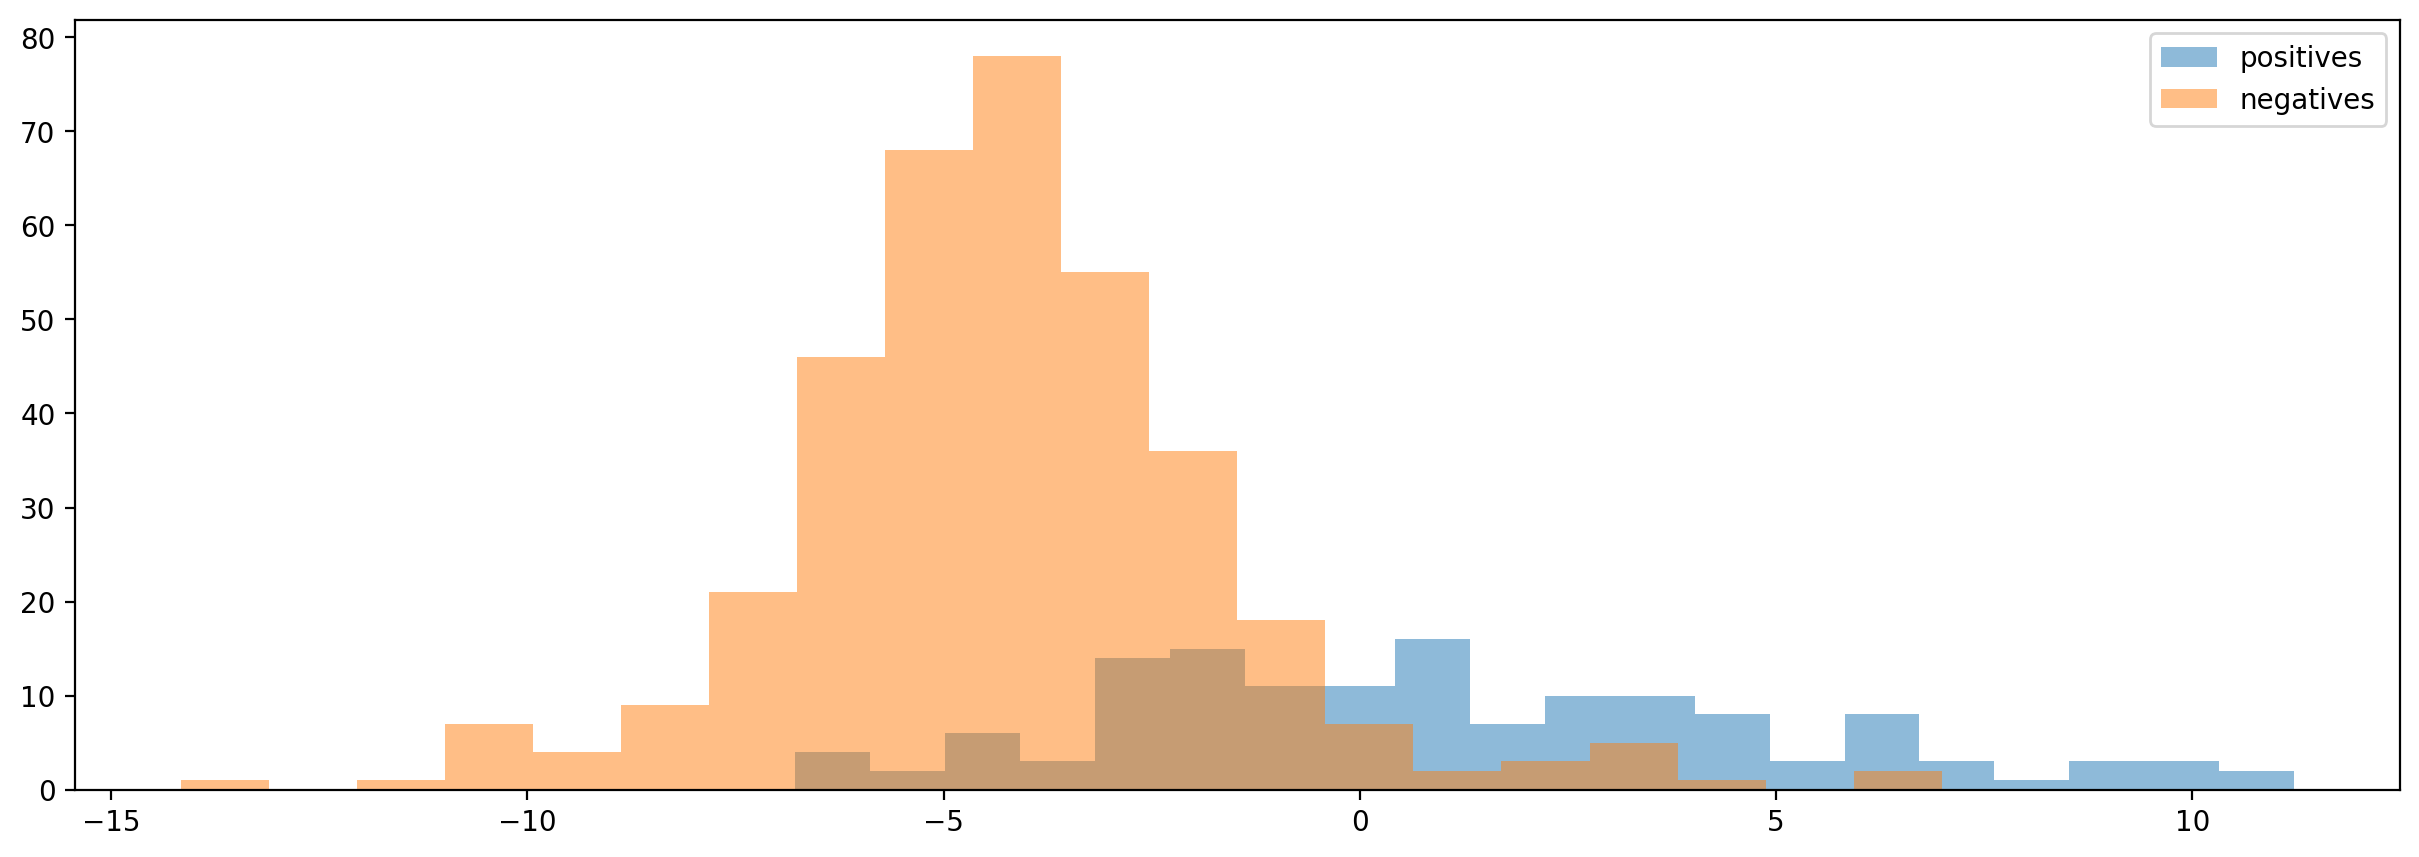

In [19]:
# make predictions by passing the embeddings through the classifier
preds = birdnet.network(torch.tensor(emb_val)).detach()
# calculate the area under the ROC score
print(f"auc roc score: {roc_auc_score(labels_val.values, preds, average=None)}")

# plot histograms
preds = preds.detach().numpy()
plt.hist(preds[labels_val == True], bins=20, alpha=0.5, label="positives")
plt.hist(preds[labels_val == False], bins=20, alpha=0.5, label="negatives")
plt.legend()

### including variants of the training samples using augmentation
Augmentation is a powerful technique for avoiding over-fitting and helping machine learning models generalize. The .predict() function gives us an option to perform stochastic augmentations of the training samples, thereby creating variations of the embeddings to increase the effective size of our training data. We use the `n_augmentation_variants` parameter to choose the number of variations: by default this parameter is 0 and no augmentation is performed. Here we choose to create 2 variations of each training sample using augmentation - in practice, it may be helpful to create 8 or more variations of each training sample, but note that the time to create the embeddings will be proportional to the number of variations you create. 

In [ ]:
# revert to a 1-layer classification head
birdnet.initialize_custom_classifier(hidden_layer_sizes=[], classes=classes)
birdnet.train(
    train_df=labels_train,
    validation_df=labels_val,
    n_augmentation_variants=2,
    embedding_batch_size=128,
    embedding_num_workers=num_workers,
    steps=1000,
)

Embedding the training samples 2 times with stochastic augmentation


  0%|          | 0/2 [00:00<?, ?it/s]

Embedding the validation samples


  0%|          | 0/4 [00:00<?, ?it/s]

Fitting the classifier
Epoch 100/1000, Loss: 0.506512463092804, Val Loss: 0.37380582094192505
val AU ROC: 0.805
val MAP: 0.805
Epoch 200/1000, Loss: 0.47787758708000183, Val Loss: 0.3563506603240967
val AU ROC: 0.800
val MAP: 0.800


/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/shallow_classifier.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels, dtype=torch.float32, device=device)
/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

Epoch 300/1000, Loss: 0.46161022782325745, Val Loss: 0.360210657119751
val AU ROC: 0.795
val MAP: 0.795
Epoch 400/1000, Loss: 0.44924747943878174, Val Loss: 0.37169885635375977
val AU ROC: 0.793
val MAP: 0.793
Epoch 500/1000, Loss: 0.438944548368454, Val Loss: 0.3872913122177124
val AU ROC: 0.786
val MAP: 0.786
Epoch 600/1000, Loss: 0.43000495433807373, Val Loss: 0.4047992527484894
val AU ROC: 0.781
val MAP: 0.781
Epoch 700/1000, Loss: 0.4220561683177948, Val Loss: 0.42284655570983887
val AU ROC: 0.778
val MAP: 0.778
Epoch 800/1000, Loss: 0.414864182472229, Val Loss: 0.44069230556488037
val AU ROC: 0.775
val MAP: 0.775
Epoch 900/1000, Loss: 0.40827280282974243, Val Loss: 0.457992821931839
val AU ROC: 0.772
val MAP: 0.772
Epoch 1000/1000, Loss: 0.40217331051826477, Val Loss: 0.47462737560272217
val AU ROC: 0.770
val MAP: 0.770
Training complete


### Saving and loading fine-tuned models
We use the BirdNET.save(path) and BirdNET.load(path) functions to save and load models that include our custom classification heads. 

In [ ]:
birdnet.save("./saved_custom_birdnet.model")

In [24]:
# reload the saved model later, perhaps in a different script or notebook:
loaded_model = bmz.BirdNET.load("./saved_custom_birdnet.model")

# use the model to make predictions on a dataframe or on a list of audio files
preds = loaded_model.predict(labels_val.head())

File BirdNET_GLOBAL_6K_V2.4_Labels_af.txt already exists; skipping download.
downloading model from URL...
File BirdNET_GLOBAL_6K_V2.4_Model_FP16.tflite already exists; skipping download.


/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/bioacoustics_model_zoo/tensorflow_wrapper.py:223: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict

  0%|          | 0/5 [00:00<?, ?it/s]

## Train shallow classifier on Perch embeddings

Training classifiers on Perch works the same way!

Since Perch uses 5 second audio clips as inputs, we'll first re-generate clip labels for 5 second audio segments from the annotated _Rana sierrae_ dataset. 

As before, well just work on the 'A' type call for this example

As with BirdNET (see examples above): 

- our `perch` model object with the custom classification head (which is an instance of the Perch class) can be saved with `perch.save(path)` and loaded with `reloaded_model=Perch.load(path)`.

- we could perform the embedding and classifier fitting steps separately using `perch.embed(labels_val,...)` to create embeddings, then fit with `perch.network.fit(emb_train, labels_train.values, emb_val, labels_val.values)`

In [29]:
labels = annotations.clip_labels(clip_duration=5, min_label_overlap=0.2)
labels_train, labels_val = sklearn.model_selection.train_test_split(labels[["A"]])

#### Step 1: Get the Perch model from the Biaocoustics Model Zoo

In [30]:
perch = bmz.Perch()

/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:621: UserWarning: 
                    This architecture is not listed in opensoundscape.ml.cnn_architectures.ARCH_DICT.
                    It will not be available for loading after saving the model with .save() (unless using pickle=True). 
                    To make it re-loadable, define a function that generates the architecture from arguments: (n_classes, n_channels) 
                    then use opensoundscape.ml.cnn_architectures.register_architecture() to register the generating function.

                    The function can also set the returned object's .constructor_name to the registered string key in ARCH_DICT
                    to avoid this warning and ensure it is reloaded correctly by opensoundscape.ml.load_model().

                    See opensoundscape.ml.cnn_architectures module for examples of constructor functions
                    
  warnings.warn(
/Users/SML161/mini

#### Step 2: Train the shallow classifier on embeddings from the BirdNET pre-trained model

We set up a 2-layer classification head (see details above) by running `initialize_custom_classifier` with one hidden layer.

We also create 2  variants of each training sample with stochastic augmentation by setting `n_augmentation_variants=2`

In [31]:
# define classes for your custom classifier
perch.change_classes(classes)

# replace the default 1-layer classification head with a 2-layer MLP (2 fully-connected layers)
perch.initialize_custom_classifier(hidden_layer_sizes=[100], classes=classes)

# train the classifier in one step: this function first creates embeddings, then fits the classification head
perch.train(
    train_df=labels_train,
    validation_df=labels_val,
    n_augmentation_variants=2,
    embedding_batch_size=128,
    embedding_num_workers=num_workers,
    steps=1000,
)

Embedding the training samples 2 times with stochastic augmentation


  0%|          | 0/2 [00:00<?, ?it/s]

2025-01-23 19:04:01.819754: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x619acee30 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-01-23 19:04:01.819919: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-01-23 19:04:02.082205: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-23 19:04:02.127884: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert
2025-01-23 19:04:03.724750: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-01-23 19:04:03.736300: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


Embedding the validation samples


  0%|          | 0/1 [00:00<?, ?it/s]

Fitting the classifier
Epoch 100/1000, Loss: 0.016709711402654648, Val Loss: 0.4339100420475006
val AU ROC: 1.000
val MAP: 1.000
Epoch 200/1000, Loss: 0.003975787665694952, Val Loss: 0.532897412776947
val AU ROC: 1.000
val MAP: 1.000
Epoch 300/1000, Loss: 0.0018430609488859773, Val Loss: 0.5930237770080566
val AU ROC: 1.000
val MAP: 1.000


/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/shallow_classifier.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels, dtype=torch.float32, device=device)
/Users/SML161/miniconda3/envs/bmz_dev/lib/python3.10/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

Epoch 400/1000, Loss: 0.0010767888743430376, Val Loss: 0.6369003057479858
val AU ROC: 1.000
val MAP: 1.000
Epoch 500/1000, Loss: 0.0007103480165824294, Val Loss: 0.6716023683547974
val AU ROC: 1.000
val MAP: 1.000
Epoch 600/1000, Loss: 0.0005052309716120362, Val Loss: 0.7007215619087219
val AU ROC: 1.000
val MAP: 1.000
Epoch 700/1000, Loss: 0.00037842956953682005, Val Loss: 0.7257473468780518
val AU ROC: 1.000
val MAP: 1.000
Epoch 800/1000, Loss: 0.00029407197143882513, Val Loss: 0.7478455305099487
val AU ROC: 1.000
val MAP: 1.000
Epoch 900/1000, Loss: 0.00023495915229432285, Val Loss: 0.7677527666091919
val AU ROC: 1.000
val MAP: 1.000
Epoch 1000/1000, Loss: 0.00019194063497707248, Val Loss: 0.7859316468238831
val AU ROC: 1.000
val MAP: 1.000
Training complete


#### Step 3: train the classification head on the desired classes

In [ ]:
perch.change_classes(["A"])  # replace fc layer with 1-output layer
quick_fit(
    perch.network,
    emb_train,
    labels_train.values,
    emb_val,
    labels_val.values,
    steps=1000,
)

Epoch 100/1000, Loss: 0.4348709285259247, Val Loss: 0.4204502999782562
val AU ROC: 0.797
val MAP: 0.797
Epoch 200/1000, Loss: 0.38083168864250183, Val Loss: 0.3726308345794678
val AU ROC: 0.812
val MAP: 0.812
Epoch 300/1000, Loss: 0.3522585928440094, Val Loss: 0.3506649434566498
val AU ROC: 0.823
val MAP: 0.823
Epoch 400/1000, Loss: 0.3324108123779297, Val Loss: 0.33769121766090393
val AU ROC: 0.829
val MAP: 0.829
Epoch 500/1000, Loss: 0.3167117238044739, Val Loss: 0.32872632145881653
val AU ROC: 0.834
val MAP: 0.834
Epoch 600/1000, Loss: 0.3035616874694824, Val Loss: 0.321988046169281
val AU ROC: 0.837
val MAP: 0.837
Epoch 700/1000, Loss: 0.29223692417144775, Val Loss: 0.31672316789627075
val AU ROC: 0.840
val MAP: 0.840
Epoch 800/1000, Loss: 0.28230735659599304, Val Loss: 0.31254294514656067
val AU ROC: 0.842
val MAP: 0.842
Epoch 900/1000, Loss: 0.27346834540367126, Val Loss: 0.30920472741127014
val AU ROC: 0.843
val MAP: 0.843
Epoch 1000/1000, Loss: 0.2654900848865509, Val Loss: 0.3

#### Evaluate

0.9353218210361067

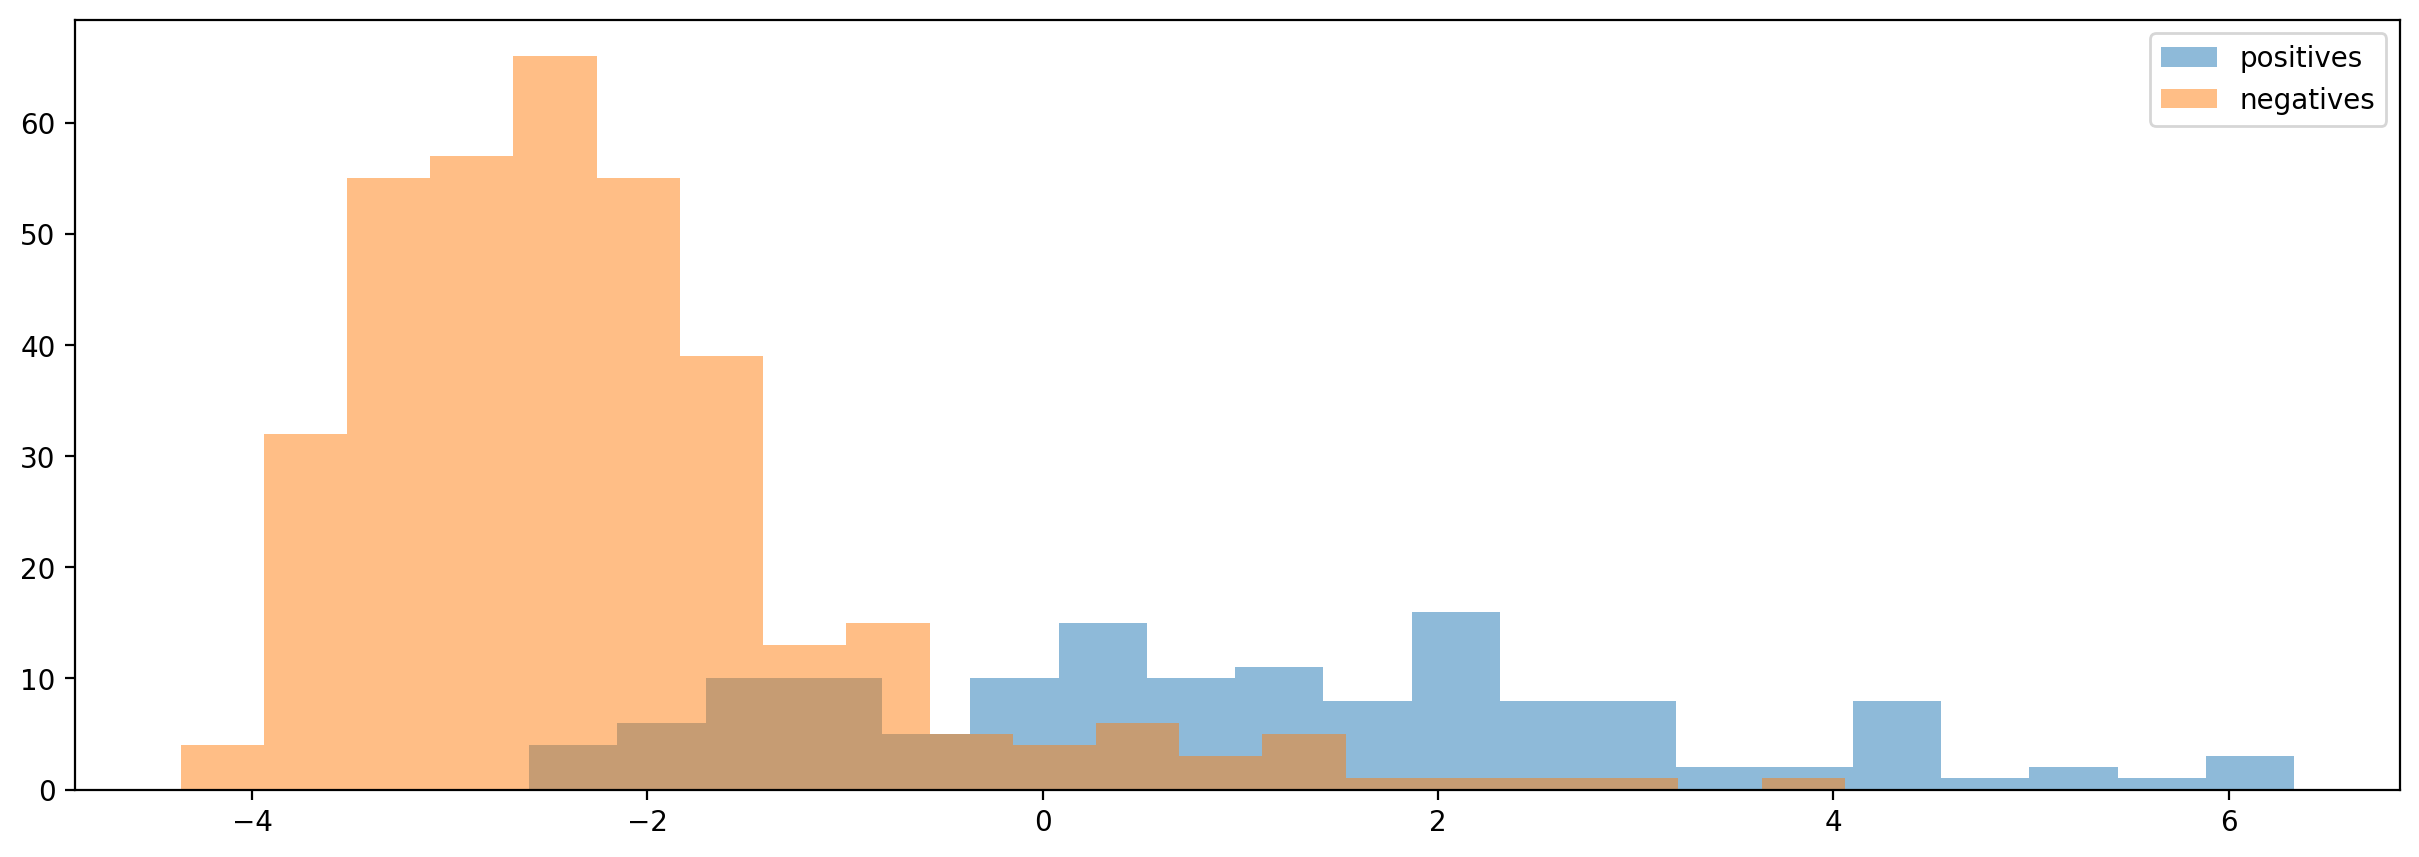

In [ ]:
# make predictions by passing the embeddings through the classifier
preds = birdnet.network(torch.tensor(emb_val).float()).detach().numpy()
# could produce the same results with the .predict() function on the label df,
# but it will be slower because it first generates the embeddings
# preds = birdnet.predict(labels_val)

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val == True], bins=20, alpha=0.5, label="positives")
plt.hist(preds[labels_val == False], bins=20, alpha=0.5, label="negatives")
plt.legend()

# calculate the area under the ROC score
roc_auc_score(labels_val.values, preds, average=None)

## Variations on training

OpenSoundscape also provides tools to generate embeddings for augmented variations of the input samples (`opensoundscape.shallow_classifier.augmented_embed()`), which could improve the classifiers performance and generalizability. See the transfer learning tutorial for further examples of this and other workflows. 

Here are a few other tools from the `shallow_classifiers` module to check out:

- augmented_embed(): generate embeddings for each sample multiple times, with stochastic augmentation on the audio clips

- fit_classifier_on_embeddings(): this function wraps together the embedding step with the classifier fitting step into a single operation, with support for generating augmented variations of training samples. It returns the embeddings and labels, in case you want to train additional classifiers on them

- MLPClassifier: this class creates a neural network with one or more fully connected layers. This object can be trained by passing it to quick_fit() or fit_classifier_on_embeddings(), or by running the MLPClassifier.fit() method (equivalent to quick_fit()). The input size should match the embedding size of the embedding model, and the output size should match the number of classes your model predicts on. 